# Summary
#  [Importing libraries](#Importing-libraries)
#  [Initial configuration](#Initial-configuration)
#  [Importing Excel spreadsheet](#Defining-functions)
#  [Importing Excel spreadsheet](#Importing-Excel-spreadsheet)
# [Setting up a local copy of the NCBI taxonomy database](#Setting-up-a-local-copy-of-the-NCBI-taxonomy-database)
# [Geting NCBI TAX IDs](#Geting-NCBI-TAX-IDs)
# [Creating dataframe with all microorganisms in the rows and the plastics in the columns](#Creating-dataframe-with-all-microorganisms-in-the-rows-and-the-plastics-in-the-columns)
# [Filling the dataframe with plastic degrading data](#Filling-the-dataframe-with-plastic-degrading-data)
# [Getting tree topology from NCBI and creating the tree](#Getting-tree-topology-from-NCBI-and-creating-the-tree)
# [Creating Itol dataset files](#Creating-Itol-dataset-files)
# [Downloading all available genomes for the plastic degraders](#Downloading-all-available-genomes-for-the-plastic-degraders)
# [Creating itol dataset for microorganisms with available genomes](#Creating-itol-dataset-for-microorganisms-with-available-genomes)
# [Blasting genes against genomes](#Blasting-genes-against-genomes)
# [Creating itol datasets for genes](#Creating-itol-datasets-for-genes)

<a id='Importing-libraries'></a>
# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import random, os, time
from ete3 import NCBITaxa
from ete3 import Tree
import seaborn as sns
import unicodedata
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import operator

<a id='Initial-configuration'></a>
# Initial configuration

In [2]:
#If running on a Slurm cluster, change account name and change run_on_slurm variable to True.
account = "uoa00354"
run_on_slurm = True

<a id='Defining-functions'></a>
# Defining functions

In [3]:
def create_directory(directory_name):
    if os.path.exists(directory_name) == False:
        os.mkdir(directory_name)
    
def run_command(run_on_slurm, account, job_name, job_time, job_memory, job_cpus, job_command):
    if run_on_slurm == False:
        os.system(job_command)
    if run_on_slurm == True:
        f = open("run.sh", "w")
        f.write("""#!/bin/bash

#SBATCH --account="""+str(account)+"""
#SBATCH --job-name="""+str(job_name)+"""
#SBATCH --time="""+str(job_time)+"""
#SBATCH --mem="""+str(job_memory)+"""
#SBATCH --cpus-per-task="""+str(job_cpus)+"""

module load Python
module load BLAST

"""+job_command)
        f.close()
    
        os.system("sbatch run.sh")  
        os.system("rm run.sh")
    else:
        print("Please, set 'run_on_slurm' variable to True or False")
        
def is_error(func, *args, **kw):
    try:
        func(*args, **kw)
        return False
    except Exception:
        return True
    
def get_rank_count_percentage(rank,tax_id_list):
    rank_dict = {}
    for tax_id in tax_id_list:
        lineage = ncbi.get_lineage(tax_id)
        for tax_id_lineage in lineage:
            sub_rank = "sub"+rank
            if rank in str(ncbi.get_rank([tax_id_lineage])) and sub_rank not in str(ncbi.get_rank([tax_id_lineage])):
                if tax_id_lineage not in rank_dict:
                    rank_dict[tax_id_lineage] = 1
                else:
                    rank_dict[tax_id_lineage] += 1
    sum = 0
    for key, value in rank_dict.items():
        sum += value
    for key, value in rank_dict.items():
        rank_dict[key] = (value/sum)*100
    return(rank_dict)

<a id='Importing-Excel-spreadsheet'></a>
# Importing Excel spreadsheet

In [20]:
df = pd.read_excel("Degraders_list_v2.xlsx")
#Visualize part of the dataset.
df.tail(7)

,Microorganism,Tax ID,Plastic,Ref,Enzyme,Gene,GenbankID,Sequence,Year,Evidence,Plastic used,Manufacturer,Analitical grade,Thermophilic conditions,Isolation sample type,Isolation environment,Isolation location,PMBD,Degradation extrapolated from enzyme
941,Paraphoma sp.,0,PBSA,"Koitabashi, M., Sameshima–Yamashita, Y., Koike...",No,No,NaN,NaN,2016,Spectrometry,Bionolle3001G,"Showa Denko K. K. - Tokyo, Japan",NaN,No,Barley,Barley,Japan,1.0,No
942,Paraphoma sp.,0,PBS,"Koitabashi, M., Sameshima–Yamashita, Y., Koike...",No,No,NaN,NaN,2016,Spectrometry,Bionolle1001G,"Showa Denko K. K. - Tokyo, Japan",NaN,No,Barley,Barley,Japan,1.0,No
943,Clostridium hathewayi,0,PBAT,"Perz, V., Hromic, A., Baumschlager, A., Steink...",Esterase,Yes,EFC94627.1,MAKQFLYDNLPVVETKAGKLRGYQWEGTYIFKGIRYARANRFQLPE...,2016,HPLC;SEM,Milled PBAT,BASF SE (Germany),Yes,No,NaN,NaN,NaN,0.0,No
944,Pseudomonas mendocina,0,P(3HB-co-4HB),"Gao, Z., Su, T., Li, P., & Wang, Z. (2017). Bi...",No,No,NaN,NaN,2017,GPC;DSC;XRD;FTIR;NMR,P(3HB-co-4HB) containing 12 mol% 4-hydroxybuty...,Shandong Ecomann Technology Co,Yes,No,NaN,NaN,NaN,1.0,No
945,Fomitopsis pinicola,0,PVA,"Tsujiyama, S., & Okada, A. (2013). Biodegradat...",No,No,NaN,NaN,2013,GPC;Emulsified plastic agar plates;Iodometric ...,"PVA [MW: approx. 90,000 or MW: approx. 50,000 ...",NacalaiTesque;Sigma Aldrich,Yes,No,NaN,NaN,NaN,1.0,No
946,Flammulina velutipes,0,PVA,"Tsujiyama, S. I., Nitta, T., & Maoka, T. (2011...",No,No,NaN,NaN,2011,Emulsified plastic agar plates;Iodometric anal...,"PVA (Mw ≈90,000)","Nacalai Tesque, Kyoto",Yes,No,NaN,NaN,NaN,1.0,No
947,Phanerochaete chrysosporium,0,PVA,"Huang, M. H., Shih, Y. P., & Liu, S. M. (2002)...",No,No,NaN,NaN,2002,COD;TOC;GPC,"PVA powder (BP05 and BF17, which have a polyme...","Chang Chun Petrochemical Co., Taiwan",No,No,NaN,Collection,NaN,1.0,No


<a id='Setting-up-a-local-copy-of-the-NCBI-taxonomy-database'></a>
# Setting up a local copy of the NCBI taxonomy database

In [6]:
ncbi = NCBITaxa()

<a id='Geting-NCBI-TAX-IDs'></a>
# Geting NCBI TAX IDs

In [23]:
#If it returns an error, just wait, it will get the dataframe anyway.
for index, row in df.iterrows():
    if row["Tax ID"] == 0:
        name2taxid = ncbi.get_name_translator([row["Microorganism"]])
        df["Tax ID"][row.name] = str(name2taxid.values()).replace("[","").replace("]","").split("(")[1].split(")")[0]
df.tail(20).head(20)

,Microorganism,Tax ID,Plastic,Ref,Enzyme,Gene,GenbankID,Sequence,Year,Evidence,Plastic used,Manufacturer,Analitical grade,Thermophilic conditions,Isolation sample type,Isolation environment,Isolation location,PMBD,Degradation extrapolated from enzyme
928,Streptomyces omiyaensis,68247,PCL,"Gangoiti, J., Santos, M., Prieto, M. A., de la...",No,No,NaN,NaN,2012,Emulsified plastic agar plates,PCL,Sigma Aldrich,Yes,No,NaN,NaN,Spain,0.0,No
929,Pseudomonas beteli,40324,P3HO,"Gangoiti, J., Santos, M., Prieto, M. A., de la...",No,No,NaN,NaN,2012,Emulsified plastic agar plates,Poly(3-hydroxyoctanoate-co-3-hydroxyhexanoate ...,"Biopolis, S.A. (Valencia, Spain)",NaN,No,NaN,NaN,Spain,0.0,No
930,Rhodococcus equi,43767,P3HO,"Gangoiti, J., Santos, M., Prieto, M. A., de la...",No,No,NaN,NaN,2012,Emulsified plastic agar plates,Poly(3-hydroxyoctanoate-co-3-hydroxyhexanoate ...,"Biopolis, S.A. (Valencia, Spain)",NaN,No,NaN,NaN,Spain,0.0,No
931,Streptomyces pulveraceus,68258,P3HO,"Gangoiti, J., Santos, M., Prieto, M. A., de la...",No,No,NaN,NaN,2012,Emulsified plastic agar plates,Poly(3-hydroxyoctanoate-co-3-hydroxyhexanoate ...,"Biopolis, S.A. (Valencia, Spain)",NaN,No,NaN,NaN,Spain,0.0,No
932,Streptomyces pulveraceus,68258,PHB,"Gangoiti, J., Santos, M., Prieto, M. A., de la...",No,No,NaN,NaN,2012,Emulsified plastic agar plates,PHB,Sigma Aldrich,Yes,No,NaN,NaN,Spain,0.0,No
933,Streptomyces pulveraceus,68258,PHBV,"Gangoiti, J., Santos, M., Prieto, M. A., de la...",No,No,NaN,NaN,2012,Emulsified plastic agar plates,PHBV,Sigma Aldrich,Yes,No,NaN,NaN,Spain,0.0,No
934,Streptomyces pulveraceus,68258,PCL,"Gangoiti, J., Santos, M., Prieto, M. A., de la...",No,No,NaN,NaN,2012,Emulsified plastic agar plates,PCL,Sigma Aldrich,Yes,No,NaN,NaN,Spain,0.0,No
935,Pseudomonas fluorescens,294,P3HO,"Gangoiti, J., Santos, M., Prieto, M. A., de la...",No,No,NaN,NaN,2012,Emulsified plastic agar plates,Poly(3-hydroxyoctanoate-co-3-hydroxyhexanoate ...,"Biopolis, S.A. (Valencia, Spain)",NaN,No,NaN,NaN,Spain,0.0,No
936,Pelosinus fermentans,365349,PBAT,"Biundo, A., Hromic, A., Pavkov-Keller, T., Gru...",Lipase,Yes,EIW29778.1,MDSVMQTKEMVMKSNVNSYPIVLVHGFMGWGRNEVLGLKYWGGITD...,2016,Spectroscopy;LC-MS,PBAT,"BASF, Germany",Yes,No,NaN,NaN,NaN,1.0,Yes
937,Bacillus thuringiensis,1428,PHB,"Wang, Y. L., Lin, Y. T., Chen, C. L., Shaw, G....",PHB-depolymerase,Yes,EAO52570.1,MGELVMIKPATMEFVSLSNGETIAYQEVGRRNTDILVLIHGNMTSS...,2014,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,1.0,Yes


<a id='Creating-dataframe-with-all-microorganisms-in-the-rows-and-the-plastics-in-the-columns'></a>
# Creating dataframe with all microorganisms in the rows and the plastics in the columns

In [24]:
plastic_types = df['Plastic'].unique()
tax_ids = df['Tax ID'].unique()
df2 = pd.DataFrame(0, index=tax_ids, columns=plastic_types)
df2.sort_index(inplace=True)
df2.sort_index(axis=1, inplace=True)
df2.head(7)

,BTA copolyester,Ecoflex,HDPE,LDPE,LDPE Blend,Mater-Bi,Nylon,Nylon 12,Nylon 4,Nylon 6,...,PTC,PTS,PU,PU Blend,PVA,PVA-LLDPE,PVC,PVC Blend,Polyether sulfone,Sky-Green
232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
239,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
285,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
292,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
294,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a id='Filling-the-dataframe-with-plastic-degrading-data'></a>
# Filling the dataframe with plastic degrading data

In [25]:
references_dict = {}
for index, row in df.iterrows():
    plastic = row['Plastic']
    tax_id = row['Tax ID']
    reference = str(row['Ref'].strip())
    normalized = unicodedata.normalize('NFD', reference)
    reference = u"".join([c for c in normalized if not unicodedata.combining(c)])+"<br><br>"
    df2.at[tax_id, plastic] = 1
    if tax_id not in references_dict.keys():
        references_dict[tax_id] = reference
    else:
        if reference not in references_dict[tax_id]:
            references_dict[tax_id] += reference
df2

,BTA copolyester,Ecoflex,HDPE,LDPE,LDPE Blend,Mater-Bi,Nylon,Nylon 12,Nylon 4,Nylon 6,...,PTC,PTS,PU,PU Blend,PVA,PVA-LLDPE,PVC,PVC Blend,Polyether sulfone,Sky-Green
232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
239,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
266,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
285,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
287,0,0,1,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
292,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
294,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
300,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
303,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
306,0,0,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


<a id='Getting-tree-topology-from-NCBI-and-creating-the-tree'></a>
# Getting tree topology from NCBI and creating the tree

In [26]:
ids = df2.index.values
t = ncbi.get_topology(ids, intermediate_nodes=True)
t.write(format=8, outfile="tree.nw")

<a id='Creating-Itol-dataset-files'></a>
# Creating Itol dataset files

In [10]:
r = lambda: random.randint(0,255) #Creates random hexadecimal color codes
create_directory("itol_datasets")

for column in df2.columns:
    f = open("itol_datasets/"+column.rstrip()+".txt", "w")
    f.write("""DATASET_BINARY
SEPARATOR COMMA
DATASET_LABEL,"""+column+"""
COLOR,"""+'#%02X%02X%02X' % (r(),r(),r())+"""
FIELD_SHAPES,1
FIELD_LABELS,f1
DATA""")
    for index, row in df2.iterrows():
        tax_id = str(index)
        feature_binary = str(row[column])
        f.write("\n"+tax_id+","+feature_binary)
    f.close()

<a id='Downloading-all-available-genomes-for-the-plastic-degraders'></a>
# Downloading all available genomes for the plastic degraders

In [45]:
for tax_id in tax_ids:
    job_name = str(tax_id)+"_download"
    job_time = "05:00:00"
    job_memory = 100 #Amount of ram memory in MB
    job_cpus = 1
    job_command = "ncbi-genome-download -s genbank --format fasta --taxid "+str(tax_id)+" -r 5 -o genomes/"+str(tax_id)+"/ fungi,bacteria"
    run_command(run_on_slurm, account, job_name, job_time, job_memory, job_cpus, job_command)
    time.sleep(2)

<a id='Creating-itol-dataset-for-microorganisms-with-available-genomes'></a>
# Creating itol dataset for microorganisms with available genomes

In [21]:
create_directory("itol_datasets_genomes")
directories_list = os.listdir("genomes")

f = open("itol_datasets_genomes/Available_genomes.txt", "w")
f.write("""DATASET_BINARY
SEPARATOR COMMA
DATASET_LABEL,Available genomes
COLOR,#FF0000
FIELD_SHAPES,1
FIELD_LABELS,f1
DATA""")

for index, row in df2.iterrows():
    tax_id = str(index)
    if str(index) in directories_list:
        f.write("\n"+tax_id+","+"1")
    else:
        f.write("\n"+tax_id+","+"0")
f.close()

<a id='Blasting-genes-against-genomes'></a>
# Blasting genes against genomes

In [44]:
#Adding the TAX ID to all sequence names
directories_list = os.listdir("genomes")
create_directory("genomes_database")
os.system("touch genomes_database/genomes.fasta")
for directory in directories_list:
    os.system("zcat genomes/"+directory+"/genbank/*/*/*genomic.fna.gz | sed s/'^>'/'>"+directory+"_"+"'/g >> genomes_database/genomes.fasta")

#Creating BLAST database
job_time = "02:00:00"
job_memory = 4096 #Amount of ram memory in MB
job_cpus = 1
job_name = "blast_db"
job_command = "makeblastdb -in genomes_database/genomes.fasta -dbtype nucl"
run_command(run_on_slurm, account, job_name, job_time, job_memory, job_cpus, job_command)

#Sending BLAST jobs
create_directory("blasts")
job_time = "02:00:00"
job_memory = 512 #Amount of ram memory in MB
job_cpus = 1
for index, row in df.iterrows():
    sequences = row["Sequence"]
    species_name = ncbi.get_taxid_translator([row["Tax ID"]])[row["Tax ID"]].replace("(","").replace(")","").replace(":","").replace(" ","_")
    if pd.notna(sequences) == True:
        for n in range(0, len(sequences.split(";"))):
            job_name = str(row["Tax ID"])+"_"+str(n)
            job_command = "echo '"+sequences.split(";")[n]+"' | tblastn -query - -db genomes_database/genomes.fasta -out blasts/"+species_name+"_"+row["Enzyme"].replace(" ","_")+"_"+str(n)+".tsv -outfmt 6"
            run_command(run_on_slurm, account, job_name, job_time, job_memory, job_cpus, job_command)
            time.sleep(2)


<a id='Creating-itol-datasets-for-all-genes'></a>
# Creating itol datasets for all genes

In [45]:
r = lambda: random.randint(0,255) #Creates random hexadecimal color codes

blast_outputs_list = os.listdir("blasts")
for file in blast_outputs_list:
    file_blast = open("blasts/"+file)
    blast = file_blast.readlines()
    file_itol = open("itol_datasets_genomes/"+file.replace("tsv", "txt"), "w")
    counting_dict = {}
    for line in blast:
        qseqid = line.rstrip().split("\t")[0]
        sseqid = line.rstrip().split("\t")[1].split("_")[0]
        pident = float(line.rstrip().split("\t")[2])
        length = int(line.rstrip().split("\t")[3])
        mismatch = int(line.rstrip().split("\t")[4])
        gapopen = int(line.rstrip().split("\t")[5])
        qstart = int(line.rstrip().split("\t")[6])
        qend = float(line.rstrip().split("\t")[7])
        sstart = float(line.rstrip().split("\t")[8])
        send = float(line.rstrip().split("\t")[9])
        evalue = float(line.rstrip().split("\t")[10])
        bitscore = float(line.rstrip().split("\t")[11])
        if evalue <= 1e-06 and pident >= 25:
            if sseqid not in counting_dict:
                counting_dict[sseqid] = 1
            else:
                counting_dict[sseqid] += 1
                
    file_itol.write("""DATASET_MULTIBAR
SEPARATOR TAB
DATASET_LABEL\t"""+file.replace('.tsv', '').replace('_', ' ')+"""
COLOR\t"""+'#%02X%02X%02X' % (r(),r(),r())+"""
FIELD_COLORS\t"""+'#%02X%02X%02X' % (r(),r(),r())+"""
FIELD_LABELS\t"""+file.replace('.tsv', '').replace('_', ' ')+"""
DATA""")    
    for index, row in df2.iterrows():
        if str(index) in counting_dict:
            file_itol.write("\n"+str(index)+"\t"+str(counting_dict[str(index)]))
        else:
            file_itol.write("\n"+str(index)+"\t0")
    file_blast.close()
    file_itol.close()

<a id='Creating-one-light-color-for-each-phylum'></a>
# Creating one light color for each phylum

In [12]:
phylum_color_dict = {}
phylum_color_list = []
for node in t.traverse("postorder"):
    if "'phylum'" in str(ncbi.get_rank([int(node.name)])):
        phylum_name = ncbi.get_taxid_translator([int(node.name)])[int(node.name)]
        phylum_color_list.append(phylum_name)
phylum_colors = sns.color_palette("hls", (len(phylum_color_list))).as_hex()
n = 0
for item in phylum_color_list:
    phylum_color_dict[item] = phylum_colors[n]
    n += 1

<a id='Creating-itol-datasets-for-phylum-labels'></a>
# Creating itol datasets for phylum labels

In [17]:
'''
#Nexus version
f = open("itol_datasets/Phylum_labels.txt", "w")
f.write("""DATASET_TEXT
SEPARATOR COMMA
DATASET_LABEL,Phylum Labels
COLOR,#ff0000
MARGIN,0
SHOW_INTERNAL,1
LABEL_ROTATION,0
STRAIGHT_LABELS,0
ALIGN_TO_TREE,0
SIZE_FACTOR,0
DATA
""")
for node in t.traverse("postorder"):
    if "'phylum'" in str(ncbi.get_rank([int(node.name)])):
        phylum_name = ncbi.get_taxid_translator([int(node.name)])[int(node.name)]
        f.write("\ninode"+node.name+","+phylum_name+",0,"+phylum_color_dict[phylum_name]+",bold,10,0")      
f.close()

#XML version

ids = df2.index.values

f = open("itol_datasets/Phylum_labels.txt", "w")
f.write("""DATASET_TEXT
SEPARATOR COMMA
DATASET_LABEL,Phylum Labels
COLOR,#ff0000
MARGIN,0
SHOW_INTERNAL,1
LABEL_ROTATION,0
STRAIGHT_LABELS,0
ALIGN_TO_TREE,0
SIZE_FACTOR,0
DATA
phylum_dict = get_rank_count_percentage("phylum", ids)
for key, value in phylum_dict.items():
    phylum_name = ncbi.get_taxid_translator([key])[key]
    f.write("\n"+str(key)+","+phylum_name+",0,"+phylum_color_dict[phylum_name]+",bold,10,0")
f.close()

'''
ids = df2.index.values
internal_node_dict = {"Mucoromycota": "I735", 
                      "Bacteroidetes": "I444",
                      "Cyanobacteria": "I227",
                      "Basidiomycota": "I677",
                      "Firmicutes": "I134",
                      "Actinobacteria": "I4",
                      "Proteobacteria": "I236",
                      "Ascomycota": "I461"}
f = open("itol_datasets/Phylum_labels.txt", "w")
f.write("""DATASET_TEXT
SEPARATOR COMMA
DATASET_LABEL,Phylum Labels
COLOR,#ff0000
MARGIN,0
SHOW_INTERNAL,1
LABEL_ROTATION,0
STRAIGHT_LABELS,0
ALIGN_TO_TREE,0
SIZE_FACTOR,0
DATA
""")
phylum_dict = get_rank_count_percentage("phylum", ids)
for key, value in phylum_dict.items():
    phylum_name = ncbi.get_taxid_translator([key])[key]
    f.write("\n"+internal_node_dict[phylum_name]+","+phylum_name+",0,"+phylum_color_dict[phylum_name]+",bold,10,0")
f.close()

<a id='Creating-itol-datasets-for-phylum-colored-ranges'></a>
# Creating itol datasets for phylum colored ranges

In [18]:
'''
f = open("itol_datasets/Phylum_colors.txt", "w")
f.write("""TREE_COLORS
SEPARATOR COMMA
DATA
""")
for node in t.traverse("postorder"):
    if "'phylum'" in str(ncbi.get_rank([int(node.name)])):
        phylum_name = ncbi.get_taxid_translator([int(node.name)])[int(node.name)]
        f.write("\ninode"+node.name+",range,"+phylum_color_dict[phylum_name]+","+phylum_name)
f.close()

'''

f = open("itol_datasets/Phylum_colors.txt", "w")
f.write("""TREE_COLORS
SEPARATOR COMMA
DATA
""")
phylum_dict = get_rank_count_percentage("phylum", ids)
for key, value in phylum_dict.items():
    phylum_name = ncbi.get_taxid_translator([key])[key]
    f.write("\n"+internal_node_dict[phylum_name]+",range,"+phylum_color_dict[phylum_name]+","+phylum_name)
f.close()

<a id='Creating-itol-datasets-for-references'></a>
# Creating itol datasets for references

In [15]:
f = open("itol_datasets/Popup_info.txt", "w")
f.write("""POPUP_INFO
SEPARATOR TAB
DATA
""")
for index, row in df2.iterrows():
    organism_name = ncbi.get_taxid_translator([index])[index]
    html_string = "<h1>"+organism_name+"</h1><br>NCBI ID = "+str(index)+"<br><br>References:<br><br>"+references_dict[index]
    f.write("\n"+str(index)+"\t"+organism_name+"\t"+html_string)
f.close()

<a id='Creating-file-with-TAX-IDs'></a>
# Creating file with TAX IDs

In [79]:
ids = df2.index.values
f = open("ids.txt", "w")
for item in ids:
    f.write(str(item)+"\n")
f.close()

<a id='Creating-tree-with-all-species'></a>
# Creating tree with all species

In [87]:
#Full Bacteria and Fungi version
# all_species_file = open("all_species_tax_ids.txt")
# all_species = all_species_file.readlines()
# all_bacteria_and_fungi = []
# for item in all_species:
#     tax_id = item.rstrip()
#     if is_error(ncbi.get_lineage, tax_id) == False:
#         lineage = ncbi.get_lineage(tax_id)
#         is_bacteria_or_fungi = 0
#         is_unclassified = 0
#         is_candidatus = 0
#         for sub_item in lineage:
#             if sub_item == 2 or sub_item == 4751:
#                 is_bacteria_or_fungi = 1
#             if sub_item == 2323 or sub_item == 89443 or sub_item == 48479:
#                 is_unclassified = 1
#             if "Candidatus" in ncbi.get_taxid_translator([str(sub_item)])[sub_item]:
#                 is_candidatus = 1
#             if "candidate" in ncbi.get_taxid_translator([str(sub_item)])[sub_item]:
#                 is_candidatus = 1
#         if is_bacteria_or_fungi == 1 and is_unclassified == 0 and is_candidatus == 0:
#             all_bacteria_and_fungi.append(tax_id)          
# all_bacteria_and_fungi_subsample = random.sample(all_bacteria_and_fungi, 7000)                              

# for item in ids:
#     all_bacteria_and_fungi_subsample.append(str(item))
# t_all_species = ncbi.get_topology(all_bacteria_and_fungi_subsample, intermediate_nodes=True)
# t_all_species.write(format=8, outfile="tree_all_species.nw")
f = open("all_species_tax_ids_subsampled.txt", "w")
for item in all_bacteria_and_fungi_subsample:
    f.write(item+"\n")
f.close()

<a id='Creating-one-light-color-for-each-phylum-for-all-species-tree'></a>
# Creating one light color for each phylum for all species tree

In [22]:
phylum_color_dict_all_species = {}
phylum_color_list_all_species = []
for node in t_all_species.traverse("postorder"):
    if "'phylum'" in str(ncbi.get_rank([int(node.name)])):
        phylum_name = ncbi.get_taxid_translator([int(node.name)])[int(node.name)]
        phylum_color_list_all_species.append(phylum_name)
phylum_colors = sns.color_palette("hls", (len(phylum_color_list_all_species))).as_hex()
n = 0
for item in phylum_color_list_all_species:
    phylum_color_dict_all_species[item] = phylum_colors[n]
    n += 1

NameError: name 't_all_species' is not defined

<a id='Creating-itol-datasets-for-phylum-colored-ranges-for-all-species-tree'></a>
# Creating itol datasets for phylum colored ranges for all species tree

In [54]:
f = open("itol_datasets/Phylum_colors_all_species.txt", "w")
f.write("""TREE_COLORS
SEPARATOR COMMA
DATA
""")
for node in t_all_species.traverse("postorder"):
    if "'phylum'" in str(ncbi.get_rank([int(node.name)])):
        phylum_name = ncbi.get_taxid_translator([int(node.name)])[int(node.name)]
        f.write("\ninode"+node.name+",range,"+phylum_color_dict_all_species[phylum_name]+","+phylum_name)
f.close()

<a id='Creating-itol-datasets-for-phylum-labels-for-all-species-tree'></a>
# Creating itol datasets for phylum labels for all species tree

In [55]:
f = open("itol_datasets/Phylum_labels_all_species.txt", "w")
f.write("""DATASET_TEXT
SEPARATOR COMMA
DATASET_LABEL,Phylum Labels
COLOR,#ff0000
MARGIN,0
SHOW_INTERNAL,1
LABEL_ROTATION,0
STRAIGHT_LABELS,0
ALIGN_TO_TREE,0
SIZE_FACTOR,0
DATA
""")
for node in t_all_species.traverse("postorder"):
    if "'phylum'" in str(ncbi.get_rank([int(node.name)])):
        phylum_name = ncbi.get_taxid_translator([int(node.name)])[int(node.name)]
        f.write("\ninode"+node.name+","+phylum_name+",0,"+phylum_color_dict_all_species[phylum_name]+",bold,10,0")      
f.close()

<a id='Creating-itol-bar-dataset-for-all-species-tree'></a>
# Creating itol bar dataset for all species tree

In [56]:
file_itol = open("itol_datasets/bar_all_species.txt", "w")
file_itol.write("""DATASET_MULTIBAR
SEPARATOR TAB
DATASET_LABEL\tAll Species Bar
COLOR\t#0000ff
FIELD_COLORS\t#0000ff
FIELD_LABELS\tAll Species Bar
DATA""")    
for index, row in df2.iterrows():
    file_itol.write("\n"+str(index)+"\t10")
file_itol.close()

<a id='Creating-figure-with-number-of-publications-and-degraders-per-year'></a>
# Creating figure with number of publications and degraders per year

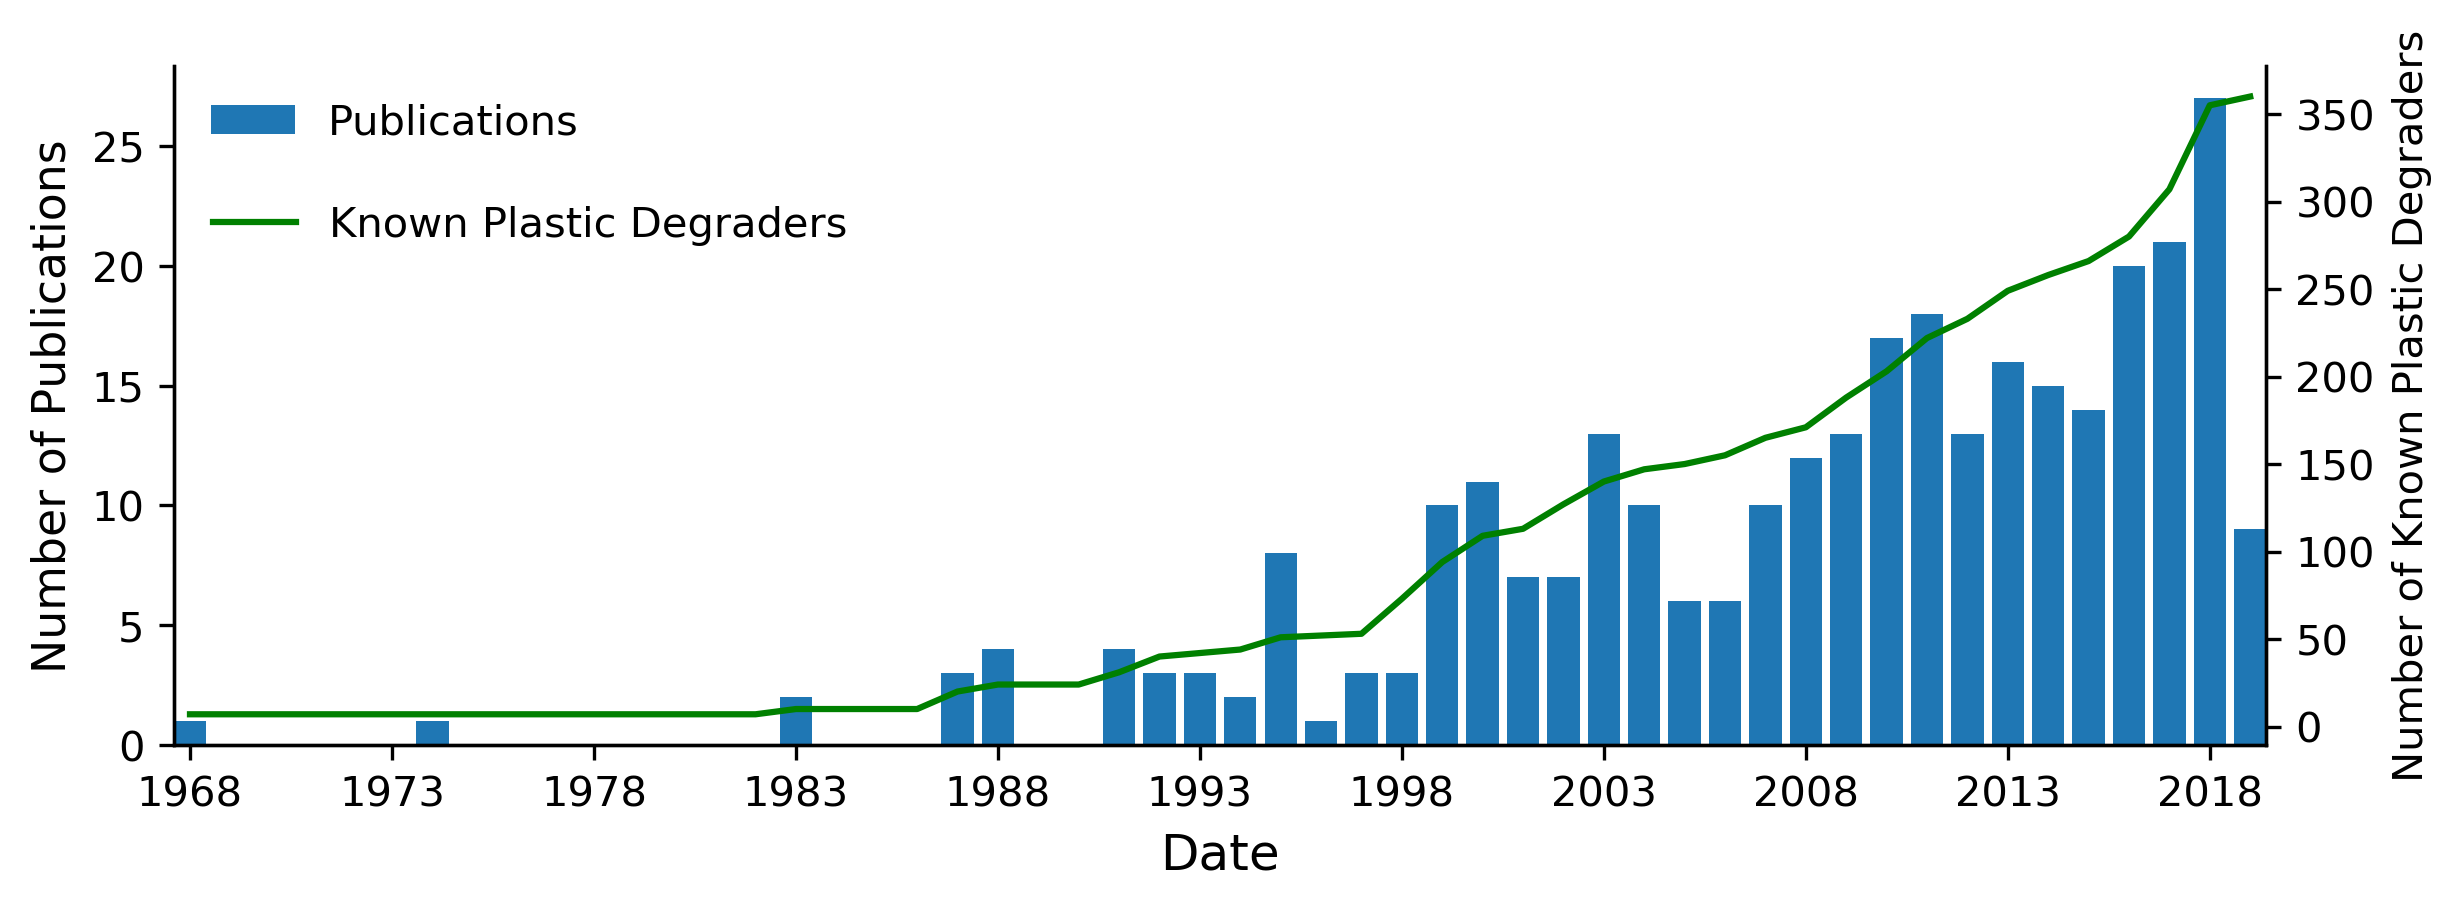

In [57]:
ref_dict, publication_count_dict = {}, {}
year_list = []

for index, row in df.iterrows():
    reference = row['Ref']
    year = row['Year']
    ref_dict[reference] = year

for key, value in ref_dict.items():
    year_list.append(value)
    if value not in publication_count_dict:
        publication_count_dict[value] = 1
    else:
        publication_count_dict[value] += 1

x, y = [], []

year_min = min(year_list)
year_max = max(year_list)

for n in range(year_min, year_max+1):
    if n in publication_count_dict:
        count = publication_count_dict[n]
        x.append(n)
        y.append(count)
    else:
        x.append(n)
        y.append(0)

figure(num=None, figsize=(9, 3), dpi=300, facecolor='w', edgecolor='k')
plt.clf()

ax1=plt.gca()
ax1.bar(x, y, label = "Publications")
ax1.set_ylabel("Number of Publications", fontsize=11)
ax1.set_xlabel("Date", fontsize=12)
ax1.legend(loc=0, frameon=False)
ax1.spines['top'].set_visible(False)

ids_year_dict = {}
year_count_dict = {}
x, y = [], []

for index, row in df.iterrows():
    ids = row['Tax ID']
    year = row['Year']
    if ids not in ids_year_dict:
        ids_year_dict[ids] = year
    else:
        if year < ids_year_dict[ids]:
            ids_year_dict[ids] = year

for key, value in ids_year_dict.items():
    if value not in year_count_dict:
        year_count_dict[value] = 1
    else:
        year_count_dict[value] += 1

year_sum = 0
for n in range(1968, 2020):
    if n in year_count_dict:
        year_sum += year_count_dict[n]
    x.append(n)
    y.append(year_sum)

ax2=ax1.twinx()
ax2.plot(x, y, color='green', label = "Known Plastic Degraders")
ax2.set_xticks(range(min(x), max(x)+1, 5))
ax2.set_ylabel("Number of Known Plastic Degraders", fontsize=10)
ax2.set_xlabel("Date", fontsize=12)
ax2.legend(loc=0, bbox_to_anchor=(0.34, 0.85,), frameon=False)
ax2.spines['top'].set_visible(False)

plt.margins(x=0)
plt.show()  

<a id='Creating-figure-with-stacked-bars-to-show-relative-abundance'></a>
# Creating figure with stacked bars to show relative abundance

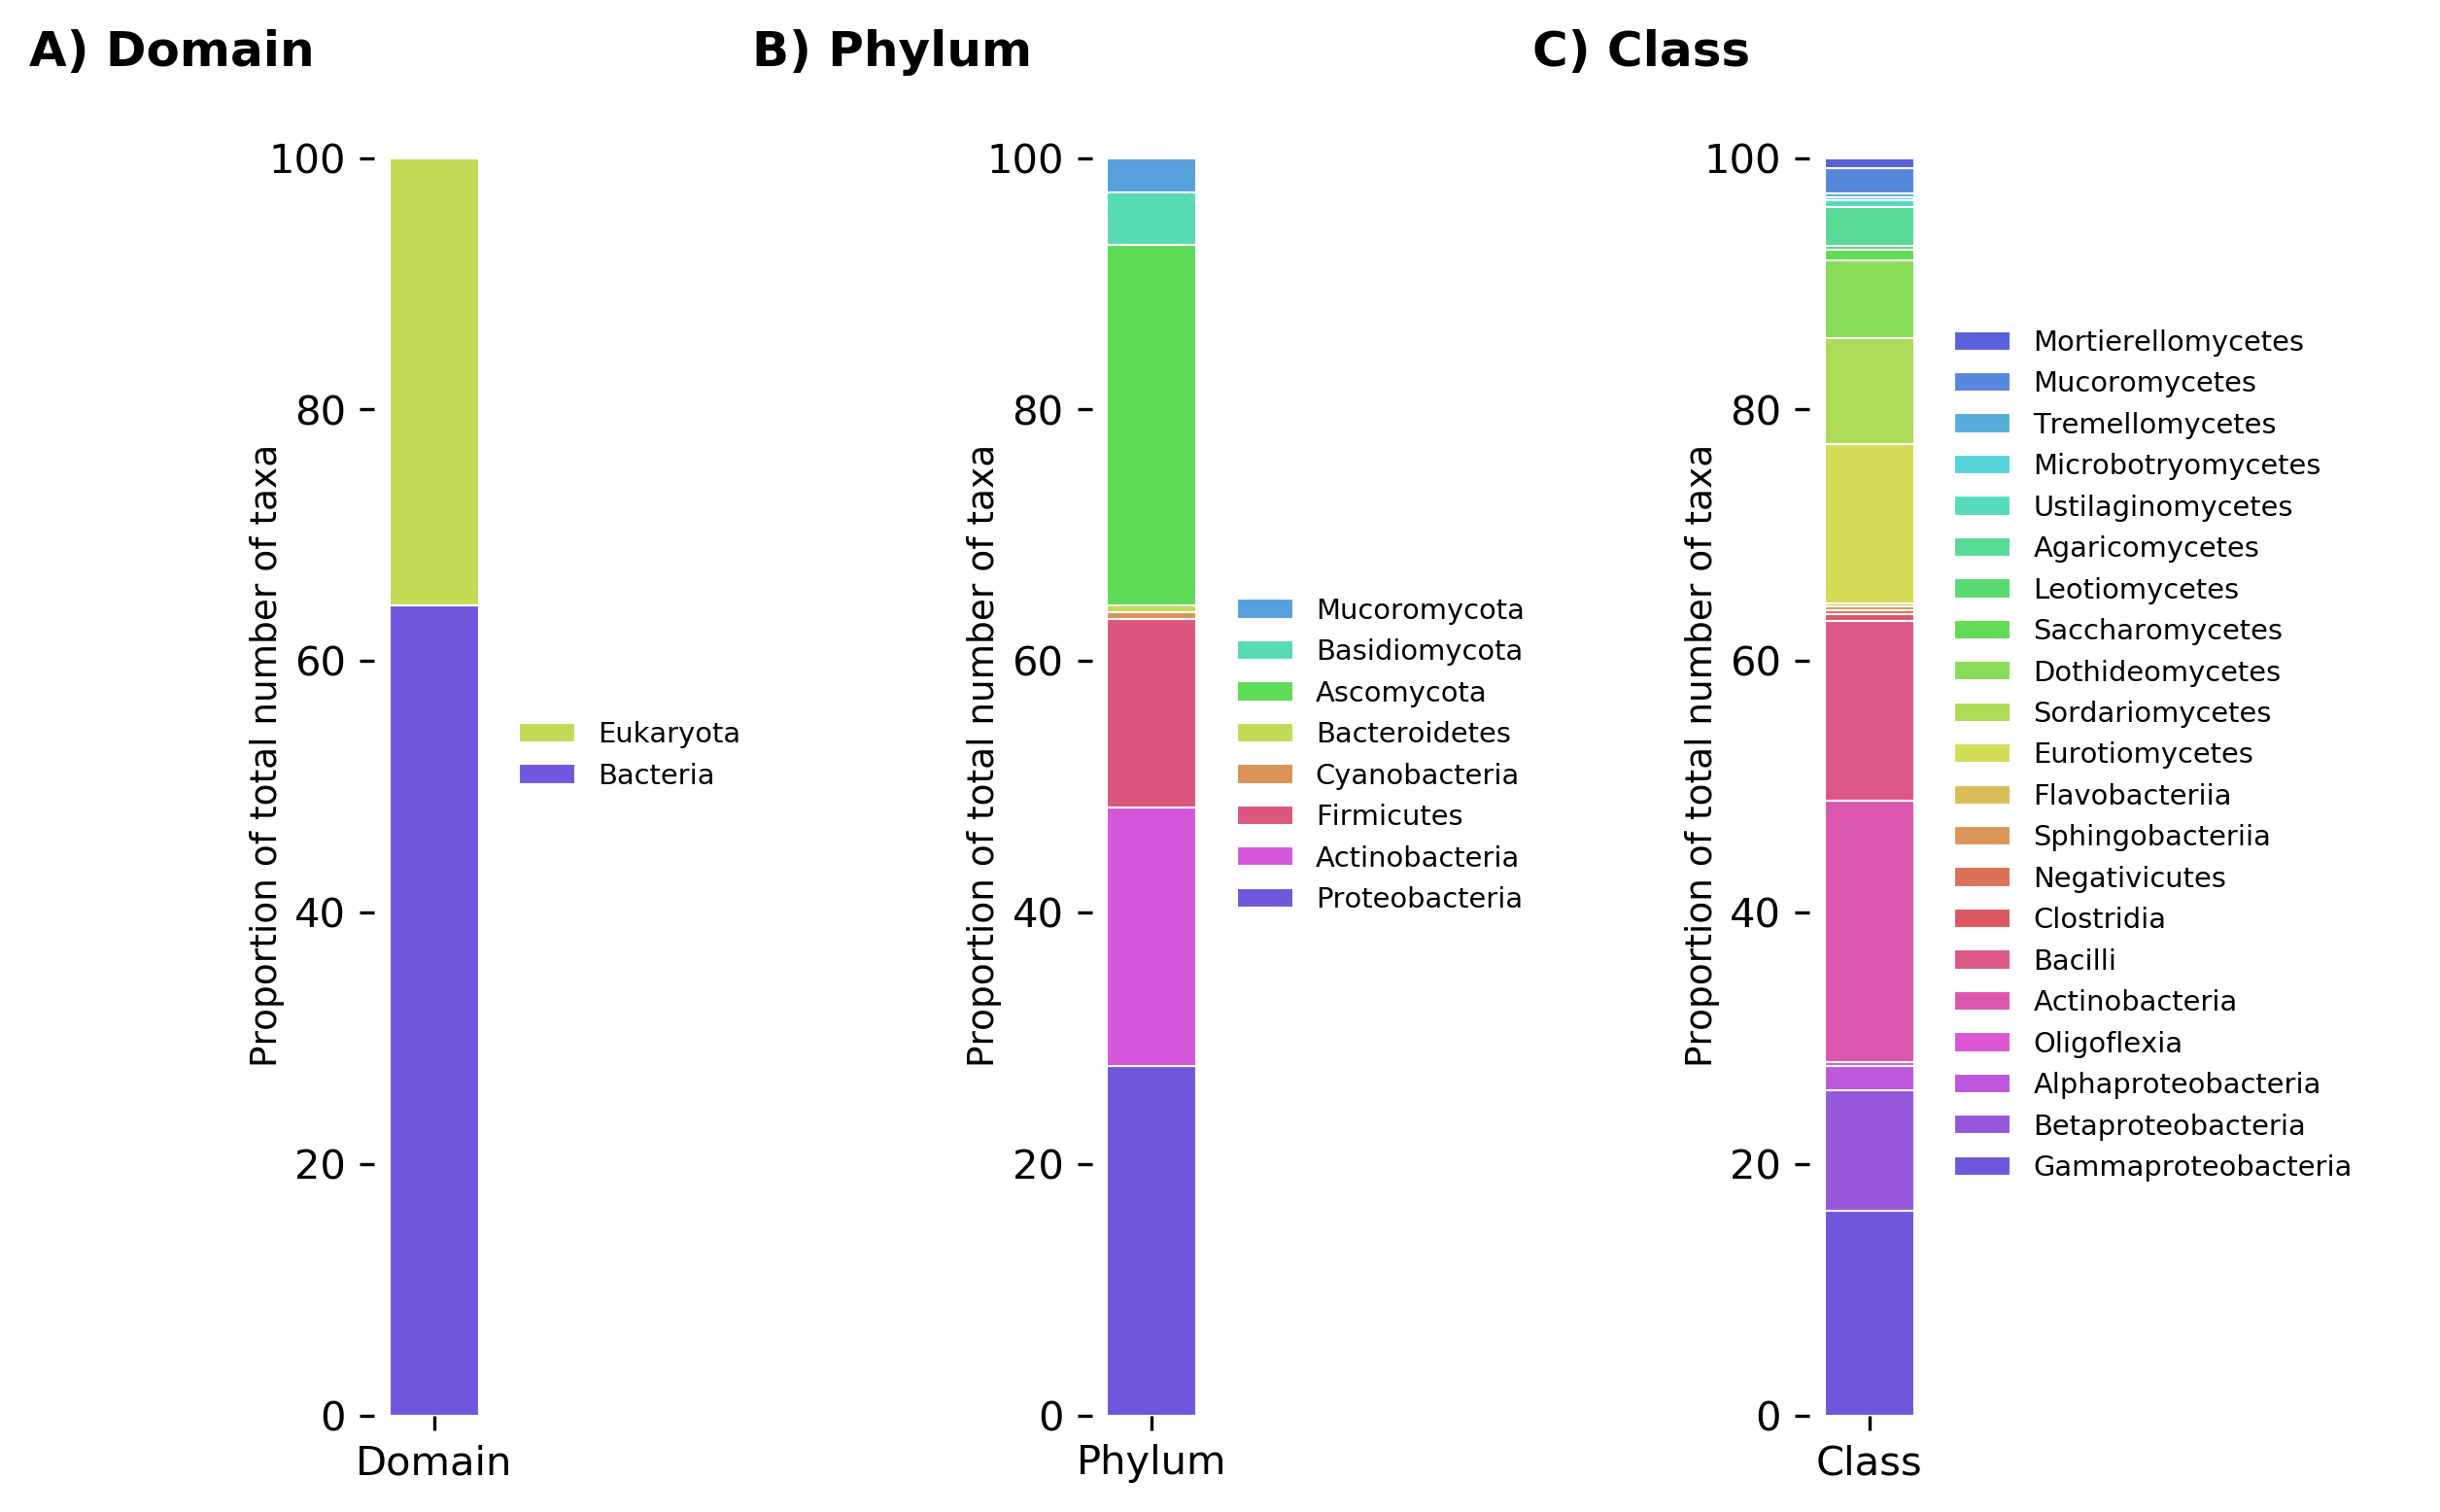

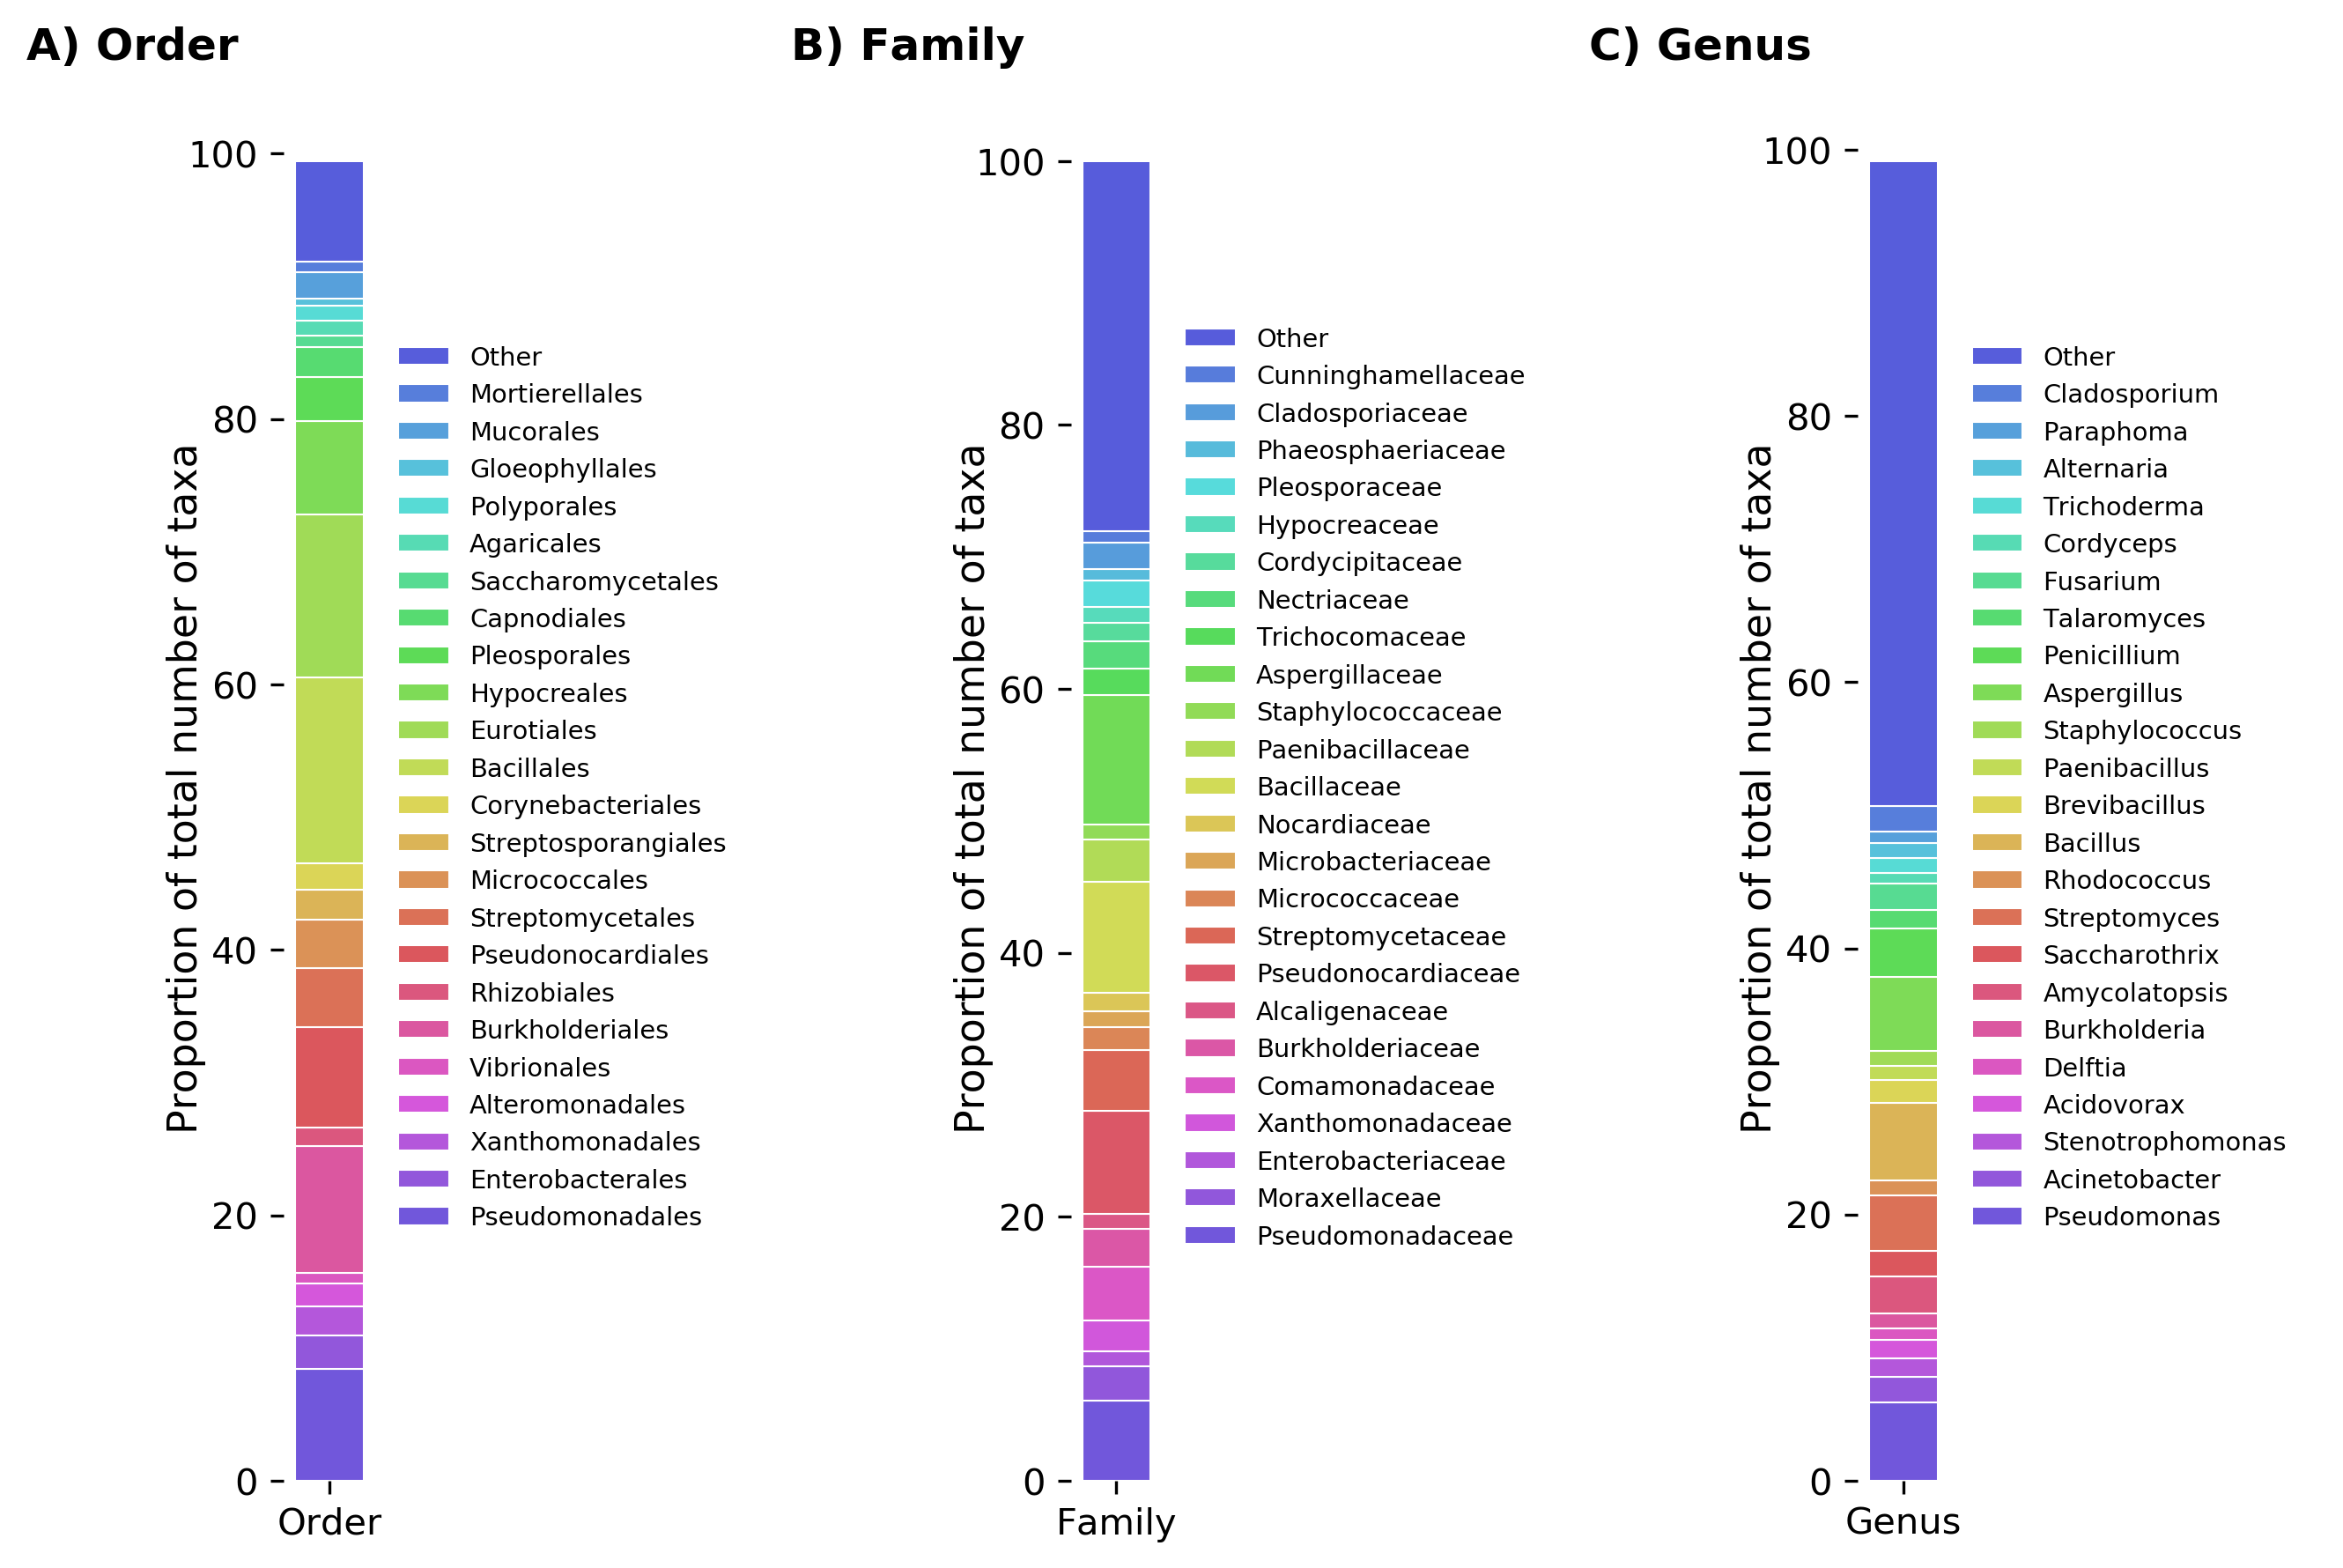

In [78]:
ids = df2.index.values

#Figure 1
figure(num=None, figsize=(9, 6), dpi=300, facecolor='w', edgecolor='k')
levels_list = ["superkingdom", "phylum", "class"]
fig_number = 1
top_label_list = ["A) Domain", "B) Phylum", "C) Class"]

upper_level_list_old = []
upper_level_list_new = []
    
for level in levels_list:
    ax = plt.subplot(1, 3, fig_number)
    

    x, y = [], []
    level_dict = get_rank_count_percentage(level, ids)
    sorted_level = sorted(level_dict.items(), key=operator.itemgetter(1))[::-1]

    
    if fig_number == 1:
        for key, value in sorted_level:
            organism_name = ncbi.get_taxid_translator([key])[key]
            count = value
            x.append(organism_name)
            y.append(count)
            upper_level_list_old.append(key)
    else:
        for item in upper_level_list_old:  
            for key, value in sorted_level:
                organism_name = ncbi.get_taxid_translator([key])[key]
                count = value
                if is_error(ncbi.get_lineage, tax_id) == False:
                    lineage = ncbi.get_lineage(key)
                    for sub_item in lineage:
                        if sub_item == item:
                            x.append(organism_name)
                            y.append(count)
                            upper_level_list_new.append(key)

        upper_level_list_old = upper_level_list_new
        upper_level_list_new = []
            
    chart_colors = sns.hls_palette(len(x), h = 0.7, l = 0.6).as_hex()

    bottom_sum = 0
    for n in range(0, len(x)):
        y_list = [y[n]]
        x_list = [x[n]]
        ax.bar(1, y_list, color = chart_colors[n], width=1.5, bottom=bottom_sum, edgecolor='white', linewidth=0.5, label=x[n])
        bottom_sum += y[n]
    ax.set_ylabel("Proportion of total number of taxa", fontsize=9)
    ax.yaxis.set_label_coords(-0.15,0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if level == "superkingdom":
        plt.xticks([1], ["Domain"])
    else:
        plt.xticks([1], [level.capitalize()])
    plt.xlim(0, 10)
    handles,labels = ax.get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], fontsize = 'x-small', frameon=False, loc="center left", bbox_to_anchor=(0.2, 0.5,))
    plt.text(-0.1, 1.05, top_label_list[fig_number-1], fontweight='bold', transform=ax.transAxes, fontsize=12, va='top', ha='right')
    
    fig_number += 1
    
    
#Figure 2
figure(num=None, figsize=(9, 6), dpi=300, facecolor='w', edgecolor='k')
levels_list = ["order", "family", "genus"]
fig_number = 1
top_label_list = ["A) Order", "B) Family", "C) Genus"]


for level in levels_list:
    ax = plt.subplot(1, 3, fig_number)
    
    x, y = [], []
    level_dict = get_rank_count_percentage(level, ids)
    sorted_level = sorted(level_dict.items(), key=operator.itemgetter(1))[::-1]
    
    
   
    sorted_level_count = 0
    sorted_level_sum = 0
    sorted_level_first_20 = []
    for key, value in sorted_level:
        if sorted_level_count < 24:
            sorted_level_first_20.append((key, value))
        else:
            if sorted_level_count == 24:
                sorted_level_first_20.append(("Other", 0))
            sorted_level_sum += value
            sorted_level_first_20[24] = ("Other", sorted_level_sum)
        sorted_level_count += 1
    
    for item in upper_level_list_old:  
        for key, value in sorted_level_first_20:
            if key != "Other":
                organism_name = ncbi.get_taxid_translator([key])[key]
                count = value
                if is_error(ncbi.get_lineage, tax_id) == False:
                    lineage = ncbi.get_lineage(key)
                    for sub_item in lineage:
                        if sub_item == item:
                            x.append(organism_name)
                            y.append(count)
                            upper_level_list_new.append(key)

    upper_level_list_old = upper_level_list_new
    upper_level_list_new = []
    x.append("Other")
    y.append(sorted_level_sum)
    
    
    chart_colors = sns.hls_palette(len(x), h = 0.7, l = 0.6).as_hex()

    bottom_sum = 0
    for n in range(0, len(x)):
        y_list = [y[n]]
        x_list = [x[n]]
        ax.bar(1, y_list, color = chart_colors[n], width=1.5, bottom=bottom_sum, edgecolor='white', linewidth=0.5, label=x[n])
        bottom_sum += y[n]
    ax.set_ylabel("Proportion of total number of taxa", fontsize=11)
    ax.yaxis.set_label_coords(-0.17,0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xticks([1], [level.capitalize()])
    plt.xlim(0, 10)
    handles,labels = ax.get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], fontsize = 'x-small', frameon=False, loc="center left", bbox_to_anchor=(0.2, 0.5,))
    plt.text(-0.1, 1.05, top_label_list[fig_number-1], fontweight='bold', transform=ax.transAxes, fontsize=12, va='top', ha='right')

    fig_number += 1
    
#Show both figures
plt.tight_layout()
plt.show()


<a id='Generating-number-of-plastic-types-degraded-by-each-species'></a>
# Generating number of plastic types degraded by each species

In [20]:
number_of_plastic_types_dict = {}
for index, row in df.iterrows():
    plastic = row['Plastic']
    tax_id = row['Tax ID']
    if tax_id not in number_of_plastic_types_dict:
        number_of_plastic_types_dict[tax_id] = [plastic]
    else:
        if plastic not in number_of_plastic_types_dict[tax_id]:
            number_of_plastic_types_dict[tax_id].append(plastic)

number_of_plastic_types_list = []
for key, value in number_of_plastic_types_dict.items():
    number_of_plastic_types_list.append([len(value), key])
number_of_plastic_types_list.sort()
print(number_of_plastic_types_list)

[[1, 232], [1, 239], [1, 285], [1, 300], [1, 317], [1, 358], [1, 479], [1, 512], [1, 549], [1, 573], [1, 663], [1, 670], [1, 959], [1, 1273], [1, 1288], [1, 1306], [1, 1397], [1, 1405], [1, 1422], [1, 1428], [1, 1479], [1, 1482], [1, 1673], [1, 1720], [1, 1785], [1, 1824], [1, 1829], [1, 1830], [1, 1833], [1, 1877], [1, 1881], [1, 1911], [1, 1934], [1, 1941], [1, 1952], [1, 2017], [1, 2026], [1, 2030], [1, 2065], [1, 2072], [1, 5045], [1, 5078], [1, 5079], [1, 5082], [1, 5325], [1, 5341], [1, 5365], [1, 5481], [1, 5516], [1, 5530], [1, 5599], [1, 12917], [1, 28031], [1, 28066], [1, 28095], [1, 28454], [1, 28565], [1, 28574], [1, 28576], [1, 29382], [1, 29446], [1, 29494], [1, 29875], [1, 33907], [1, 33919], [1, 33920], [1, 33921], [1, 33941], [1, 34028], [1, 34038], [1, 34381], [1, 35703], [1, 35841], [1, 36080], [1, 36460], [1, 36630], [1, 36773], [1, 37482], [1, 40412], [1, 40571], [1, 41061], [1, 41276], [1, 41413], [1, 41959], [1, 42190], [1, 43355], [1, 44252], [1, 44751], [1, 452

<a id='Generating-relative-abundance-for-each-taxonomic-level'></a>
# Generating relative abundance for each taxonomic level

In [58]:
x = get_rank_count_percentage("phylum", ids)
sorted_x = sorted(x.items(), key=operator.itemgetter(1))

for key, value in sorted_x:
    print(ncbi.get_taxid_translator([key])[key]+"\t"+ncbi.get_rank([key])[key]+"\t"+str(value))

Bacteroidetes	phylum	0.5747126436781609
Cyanobacteria	phylum	0.5747126436781609
Mucoromycota	phylum	2.8735632183908044
Basidiomycota	phylum	3.7356321839080464
Firmicutes	phylum	15.229885057471265
Actinobacteria	phylum	21.26436781609195
Proteobacteria	phylum	27.298850574712645
Ascomycota	phylum	28.448275862068968


<a id='Geting-number-of-plastics-degraded-by-each-taxon'></a>
# Geting number of plastics degraded by each taxon

In [19]:
tax_id_to_check = 286
plastic_types_list = []
for index, row in df.iterrows():
    plastic = row['Plastic']
    tax_id = row['Tax ID']
    lineage = ncbi.get_lineage(tax_id)
    for tax_id_lineage in lineage:
        if tax_id_to_check == tax_id_lineage and plastic not in plastic_types_list:
            plastic_types_list.append(plastic)

print(plastic_types_list)
print(len(plastic_types_list))
                

['PHB', 'HDPE', 'LDPE', 'PESu', 'PE', 'PS', 'PU Blend', 'PU', 'PBSA', 'PCL', 'PHBV', 'P3HO', 'PHPV', 'PP', 'PVC', 'P(3HB-co-3MP)', 'PHC', 'PLA', 'PEG', 'PHA Blend', 'PS Blend', 'PES', 'PHO', 'PHN', 'P3HP', 'P4HB', 'Polyether sulfone']
27


<a id='Creating-tree-with-all-phyla'></a>
# Creating tree with all phyla

In [71]:
rank_dict_degraders = {}
for tax_id in ids:
        lineage = ncbi.get_lineage(tax_id)
        for tax_id_lineage in lineage:
            sub_rank = "sub"+rank
            if rank in str(ncbi.get_rank([tax_id_lineage])) and sub_rank not in str(ncbi.get_rank([tax_id_lineage])):
                rank_dict_degraders[tax_id_lineage] = 1

f = open("itol_datasets/all_phyla_colors.txt", "w")
f.write("""TREE_COLORS
SEPARATOR COMMA
DATA
""")                
phyla_list = []                                
for key, value in rank_dict.items():
    phyla_list.append(key)
    if key in rank_dict_degraders:
        f.write("\n"+str(key)+",label,#000000,bold,1")
    else:
        f.write("\n"+str(key)+",label,#000000,normal,1")
f.write("\nI1,range,#c8df99,Bacteria")
f.write("\nI46,range,#b5c0dc,Fungi")
f.close()

t_all_phyla = ncbi.get_topology(phyla_list, intermediate_nodes=True)
t_all_phyla.write(format=8, outfile="tree_all_phyla.nw")

<a id='Downloading-rRNA-sequences-from-SILVA'></a>
# Downloading rRNA sequences from SILVA

In [30]:
create_directory("silva")

df2.to_csv(r'df2.csv')
t.write(format=5, outfile="tree_0.nw")


#os.system("wget https://www.arb-silva.de/fileadmin/silva_databases/current/Exports/SILVA_132_SSURef_tax_silva.fasta.gz" > silva/)
#os.system("gunzip silva/SILVA_132_SSURef_tax_silva.fasta.gz")

ids = df2.index.values

#file_silva = open("silva/SILVA_132_SSURef_tax_silva.fasta")
#silva = file_silva.readlines()

f = open("silva/seqs.fasta", "w")

for item in ids:
    sci_name = ncbi.get_taxid_translator([item])[item]
    to_print = False
    for line in silva:
        if to_print == True and line[0] == ">":
            to_print = False
            break
        if to_print == True:
            f.write(line.replace("U","T"))
        if sci_name in line:
            f.write(line.replace(">", ">"+str(item)+" "))
            to_print = True

f.close()

<a id='Aligning-sequences-with-MAFFT-and-creating-tree-with-FastTree'></a>
# Aligning sequences with MAFFT and creating tree with FastTree

In [18]:
os.system("module load MAFFT")
os.system("mafft --reorder --auto silva/seqs.fasta > silva/seqs_aligned.fasta")

#Download trimal
os.system("wget http://trimal.cgenomics.org/_media/trimal.v1.2rev59.tar.gz")

# Should first extract and build trimal (go to source directory and run "make")
os.system("trimal -in silva/seqs_aligned.fasta -out silva/seqs_trimal.fasta -gt 0.3 -st 0.001")
os.system("FastTree -gtr -nt silva/seqs_trimal.fasta > silva/tree.tre")
t = Tree("silva/tree.tre", format=1)
t.write(format=5, outfile="silva/tree.nw")
# Should add :0 before last ";" of tree file

<a id='Testing-phylogenetic-signal-with-CAPER'></a>
# Testing phylogenetic signal with CAPER

In [9]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [121]:
%%R -i df2
# Run bellow line if CAPER package is not installed
# install.packages("caper",lib='~/RPackages', repos = "http://cran.us.r-project.org")
library("caper", lib.loc='~/RPackages')
degraders_tree = read.tree("silva/tree.nw")
df2$TaxID = rownames(df2)
for (plastic in colnames(df2)[-c(1,2,23,57)]){
    colnames(df2)[which(names(df2) == plastic)] <- "PlasticType"
    PlasticDegraders <- comparative.data(degraders_tree, df2, TaxID)
    PlasticDegradersPhyloD <- phylo.d(PlasticDegraders,binvar=PlasticType, permut=1000)
    results_string = capture.output(print(PlasticDegradersPhyloD))
    cat(paste("Plastic type:",plastic), results_string, file="silva/caper_results.txt", sep="\n", append=TRUE)
    colnames(df2)[which(names(df2) == "PlasticType")] <- plastic
}


In [13]:
file_caper = open("silva/caper_results.txt")
caper = file_caper.readlines()
df3 = pd.DataFrame(columns=["Plastic type", "D", "Ramdon P", "Brownian P"])
n = 0
for line in caper:
    if line.startswith("Plastic type:"):
        plastic_type = line.split("Plastic type: ")[1].rstrip()
    if line.startswith("Estimated D :  "):
        d_var = line.split("Estimated D :  ")[1].rstrip()
    if line.startswith("Probability of E(D) resulting from no (random) phylogenetic structure :  "):
        ramdon_var = line.split("Probability of E(D) resulting from no (random) phylogenetic structure :  ")[1].rstrip()
    if line.startswith("Probability of E(D) resulting from Brownian phylogenetic structure    :  "):
        brownian_var = line.split("Probability of E(D) resulting from Brownian phylogenetic structure    :  ")[1].rstrip()
        df3.loc[n] = [plastic_type,d_var,ramdon_var,brownian_var]
        n += 1
df3.sort_values(by=["Brownian P"], inplace=True, ascending=False)
df3


,Plastic type,D,Ramdon P,Brownian P
10,P.3HB.co.3HP.,-1.463737,0.006,0.953
51,Polyether.sulfone,-1.469905,0.005,0.944
14,P4HB,-1.375409,0.008,0.943
13,P3HP,-1.490922,0.009,0.938
17,PBS.blend,-2.198744,0.039,0.906
19,PBSA.blend,-2.459414,0.044,0.904
15,PBAT,-1.756519,0.057,0.9
30,PHA.Blend,-1.300078,0.134,0.848
36,PHN,-1.266799,0.11,0.847
37,PHO,-1.582614,0.121,0.842


<a id='Testing-phylogenetic-signal-with-CAPER'></a>

# Creating tree with plastic degrading enzymes blasted against nr database

In [44]:
create_directory("online_blast")

#Blast individual protein sequences using online blastp tool
#Filter to e-value of 1e-6 and percent identity of > 25%
#Dowload report in txt format and save in the online_blast folder

#os.system('grep "^>" online_blast/Ideonella_sakaiensis_PETase.txt | sed s/"\[\["/"\["/g | cut -f2 -d"[" | sed s/"\]"/""/g | sort -u > online_blast/Ideonella_sakaiensis_PETase_species.txt')
#os.system('grep "^>" online_blast/Saccharomonospora_viridis_Cutinase.txt | sed s/"\[\["/"\["/g | cut -f2 -d"[" | sed s/"\]"/""/g | sort -u > online_blast/Saccharomonospora_viridis_Cutinase_species.txt')
#os.system('grep "^>" online_blast/Fusarium_verticillioides_Cutinase.txt | sed s/"\[\["/"\["/g | cut -f2 -d"[" | sed s/"\]"/""/g | sort -u > online_blast/Fusarium_verticillioides_Cutinase_species.txt')

blasts1_species, blasts2_species, blasts3_species, = {}, {}, {}
file_blasts1 = open("online_blast/Ideonella_sakaiensis_PETase_species.txt")
blasts1 = file_blasts1.readlines()
for line in blasts1:
    if line.rstrip() not in blasts1_species:
        blasts1_species[line.rstrip()] = 0

file_blasts2 = open("online_blast/Saccharomonospora_viridis_Cutinase_species.txt")
blasts2 = file_blasts2.readlines()
for line in blasts2:
    if line.rstrip() not in blasts2_species:
        blasts2_species[line.rstrip()] = 0

file_blasts3 = open("online_blast/Fusarium_verticillioides_Cutinase_species.txt")
blasts3 = file_blasts3.readlines()
for line in blasts3:
    if line.rstrip() not in blasts3_species:
        blasts3_species[line.rstrip()] = 0

all_species_dict = {**blasts1_species, **blasts2_species, **blasts3_species}

all_species_list = []
for key, value in all_species_dict.items():
    all_species_list.append(key)

y_axis = ["Tax_id", "Ideonella_sakaiensis_PETase", 
          "Saccharomonospora_viridis_Cutinase", "Fusarium_verticillioides_Cutinase"]

df4 = pd.DataFrame(0, index=all_species_list, columns=y_axis)
df4.sort_index(inplace=True)
df4.sort_index(axis=1, inplace=True)

for index, row in df4.iterrows():
    if row["Tax_id"] == 0:
        name2taxid = ncbi.get_name_translator([index])
        if "{}" not in str(name2taxid):
            df4["Tax_id"][row.name] = str(name2taxid).split("[")[1].split("]")[0]
df4.tail(20)
df4.to_csv(r'df4.csv')

/home/vmar559/PyPackages/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<a id='Testing-phylogenetic-signal-with-CAPER'></a>

# Reading curated file

In [48]:
df4 = pd.read_csv("df4_curated.csv", index_col=0)
#Visualize part of the dataset.
for index, row in df4.iterrows():
    species = index
    if species in blasts1_species:
        row['Ideonella_sakaiensis_PETase'] = 1
    if species in blasts2_species:
        row['Saccharomonospora_viridis_Cutinase'] = 1
    if species in blasts3_species:
        row['Fusarium_verticillioides_Cutinase'] = 1
df4.tail(20)

,Fusarium_verticillioides_Cutinase,Ideonella_sakaiensis_PETase,Saccharomonospora_viridis_Cutinase,Tax_id
Zymoseptoria brevis,1,0,0,1047168
Zymoseptoria tritici IPO323,1,0,0,336722
Zymoseptoria tritici ST99CH_1A5,1,0,0,1276529
Zymoseptoria tritici ST99CH_1E4,1,0,0,1276532
Zymoseptoria tritici ST99CH_3D1,1,0,0,1276537
Zymoseptoria tritici ST99CH_3D7,1,0,0,1276538
fungal sp. No.11243,1,0,0,1603295
fungal sp. No.14919,1,0,0,1813822
synthetic construct,1,1,1,32630
unclassified Actinoalloteichus,0,1,1,2644606


<a id='Testing-phylogenetic-signal-with-CAPER'></a>

# Download all genomes from NCBI

In [ ]:
create_directory("all_genomes")
os.system("wget ftp://ftp.ncbi.nlm.nih.gov/genomes/refseq/bacteria/assembly_summary.txt")
os.system("mv assembly_summary.txt all_genomes/")
os.system("wget ftp://ftp.ncbi.nlm.nih.gov/genomes/refseq/fungi/assembly_summary.txt")
os.system("tail -n+3 assembly_summary.txt >> all_genomes/assembly_summary.txt")
os.system("wget ftp://ftp.ncbi.nlm.nih.gov/genomes/refseq/archaea/assembly_summary.txt")
os.system("tail -n+3 assembly_summary.txt >> all_genomes/assembly_summary.txt")
f = open("all_genomes/assembly_summary.txt", "r")
file = f.readlines()
tax_id_dict = {}
for line in file[2:]:
    tax_id = line.split("\t")[5]
    if tax_id not in tax_id_dict and tax_id not in not_to_download_dict:
        create_directory("all_genomes/"+str(tax_id))
        os.system("ncbi-genome-download -s genbank --format fasta --taxid "+str(tax_id)+" -r 5 -o all_genomes/"+str(tax_id)+"/ fungi,bacteria,archaea &")
        time.sleep(1)
        tax_id_dict[tax_id] = 1
os.system("rm assembly_summary.txt")
os.system("rm all_genomes/assembly_summary.txt")


<a id='Blasting-genes-against-genomes'></a>
# Blasting genes against genomes

In [10]:
#Adding the TAX ID to all sequence names
directories_list = os.listdir("all_genomes/")
create_directory("all_genomes_database")
os.system("touch all_genomes_database/genomes.fasta")
for directory in directories_list:
    os.system("zcat all_genomes/"+directory+"/genbank/*/*/*genomic.fna.gz | sed s/'^>'/'>"+directory+"_"+"'/g >> all_genomes_database/genomes.fasta")

#Creating BLAST database
job_time = "03:00:00"
job_memory = "8GB"
job_cpus = 1
job_name = "blast_db"
job_command = "makeblastdb -in all_genomes_database/genomes.fasta -dbtype nucl"
run_command(run_on_slurm, account, job_name, job_time, job_memory, job_cpus, job_command)

#Sending BLAST jobs
create_directory("all_genomes_blasts")
job_time = "7:00:00"
job_memory = "1GB"
job_cpus = 1
for index, row in df.iterrows():
    sequences = row["Sequence"]
    species_name = ncbi.get_taxid_translator([row["Tax ID"]])[row["Tax ID"]].replace("(","").replace(")","").replace(":","").replace(" ","_")
    if pd.notna(sequences) == True:
        for n in range(0, len(sequences.split(";"))):
            job_name = str(row["Tax ID"])+"_"+str(n)
            job_command = "echo '"+sequences.split(";")[n]+"' | tblastn -query - -db all_genomes_database/genomes.fasta -out all_genomes_blasts/"+species_name+"_"+row["Enzyme"].replace(" ","_")+"_"+str(n)+".tsv -outfmt 6"
            run_command(run_on_slurm, account, job_name, job_time, job_memory, job_cpus, job_command)
            time.sleep(2)


<a id='Testing-phylogenetic-signal-with-CAPER'></a>

# Generate tree for all genomes blasts

In [23]:
blast_outputs_list = os.listdir("all_genomes_blasts")
create_directory("all_genomes_blasts_itol_datasets")

tax_id_dict = {}
for file in blast_outputs_list:
    file_blast = open("all_genomes_blasts/"+file)
    blast = file_blast.readlines()
    for line in blast:
        qseqid = line.rstrip().split("\t")[0]
        sseqid = line.rstrip().split("\t")[1].split("_")[0]
        pident = float(line.rstrip().split("\t")[2])
        length = int(line.rstrip().split("\t")[3])
        mismatch = int(line.rstrip().split("\t")[4])
        gapopen = int(line.rstrip().split("\t")[5])
        qstart = int(line.rstrip().split("\t")[6])
        qend = float(line.rstrip().split("\t")[7])
        sstart = float(line.rstrip().split("\t")[8])
        send = float(line.rstrip().split("\t")[9])
        evalue = float(line.rstrip().split("\t")[10])
        bitscore = float(line.rstrip().split("\t")[11])
        if evalue <= 1e-06 and pident >= 25:
            if sseqid not in tax_id_dict:
                tax_id_dict[sseqid] = 1

tax_id_list = []
for key, value in tax_id_dict.items():
    tax_id_list.append(key)
    
ids_degraders = df2.index.values
rank_dict_degraders = {}
rank = "phylum"
for tax_id in ids_degraders:
        lineage = ncbi.get_lineage(tax_id)
        for tax_id_lineage in lineage:
            sub_rank = "sub"+rank
            if rank in str(ncbi.get_rank([tax_id_lineage])) and sub_rank not in str(ncbi.get_rank([tax_id_lineage])):
                rank_dict_degraders[tax_id_lineage] = 1
                
all_ids = []
for item in ids_degraders:
    all_ids.append(item)
for item in tax_id_list:
    all_ids.append(item)
ids2 = []
for item in all_ids:
    if is_error(ncbi.get_lineage, item) == False:
        ids2.append(item)
rank_dict = {}
for tax_id in ids2:
    tax_id_tmp = tax_id
    lineage = ncbi.get_lineage(tax_id)
    for tax_id_lineage in lineage:
        sub_rank = "sub"+rank
        if rank in str(ncbi.get_rank([tax_id_lineage])) and sub_rank not in str(ncbi.get_rank([tax_id_lineage])):
            rank_dict[tax_id_lineage] = 1
                
f = open("all_genomes_blasts_itol_datasets/blast_colors.txt", "w")
f.write("""TREE_COLORS
SEPARATOR COMMA
DATA
""")                
phyla_list = []                               
for key, value in rank_dict.items():
    phyla_list.append(key)
    if key in rank_dict_degraders:
        f.write("\n"+str(key)+",label,#000000,bold,1")
    else:
        f.write("\n"+str(key)+",label,#000000,normal,1")
f.write("\nI9,range,#c8df99,Bacteria")
f.write("\nI1,range,#b5c0dc,Fungi")
f.close()

t_all_genomes_blasts = ncbi.get_topology(phyla_list, intermediate_nodes=True)
t_all_genomes_blasts.write(format=8, outfile="all_genomes_blasts_itol_datasets/tree_all_genomes_blasts.nw")

<a id='Creating-itol-datasets-for-all-genes'></a>
# Creating itol datasets for all genes

In [22]:
gene_colors = sns.color_palette("hls", (len(blast_outputs_list))).as_hex()
color_number = 0
rank = "phylum"
for file in blast_outputs_list:
    file_blast = open("all_genomes_blasts/"+file)
    blast = file_blast.readlines()
    file_itol = open("all_genomes_blasts_itol_datasets/"+file.replace("tsv", "txt"), "w")
    counting_dict = {}
    for line in blast:
        qseqid = line.rstrip().split("\t")[0]
        sseqid = line.rstrip().split("\t")[1].split("_")[0]
        pident = float(line.rstrip().split("\t")[2])
        length = int(line.rstrip().split("\t")[3])
        mismatch = int(line.rstrip().split("\t")[4])
        gapopen = int(line.rstrip().split("\t")[5])
        qstart = int(line.rstrip().split("\t")[6])
        qend = float(line.rstrip().split("\t")[7])
        sstart = float(line.rstrip().split("\t")[8])
        send = float(line.rstrip().split("\t")[9])
        evalue = float(line.rstrip().split("\t")[10])
        bitscore = float(line.rstrip().split("\t")[11])
        if evalue <= 1e-06 and pident >= 25:
            sseqid_tmp = sseqid
            lineage = ncbi.get_lineage(sseqid)
            for sseqid_lineage in lineage:
                sub_rank = "sub"+rank
                if rank in str(ncbi.get_rank([sseqid_lineage])) and sub_rank not in str(ncbi.get_rank([sseqid_lineage])):
                    if sseqid_lineage not in counting_dict:
                        counting_dict[sseqid_lineage] = 1
                    else:
                        counting_dict[sseqid_lineage] += 1
                
    file_itol.write("""DATASET_SIMPLEBAR
SEPARATOR COMMA
DATASET_LABEL,"""+file.split(".tsv")[0]+"""
COLOR,"""+gene_colors[color_number]+"""
FIELD_COLORS,"""+gene_colors[color_number]+"""
FIELD_LABELS,"""+file.split(".tsv")[0]+"""
LEGEND_TITLE,Blast Hits
LEGEND_SHAPES,1
LEGEND_COLORS,"""+gene_colors[color_number]+"""
LEGEND_LABELS,"""+file.split(".tsv")[0]+"""
WIDTH,200
SHOW_VALUE,1
DATA\n""") 
    for key, value in counting_dict.items():
        file_itol.write(str(key)+","+str(value)+"\n")
    file_blast.close()
    file_itol.close()
    color_number += 1

<a id='Creating-figure-with-techniques-utilized'></a>
# Creating figure with techniques utilized

In [30]:
evidence_dict = {}

for index, row in df.iterrows():
    evidence_line = row['Evidence']
    for evidence in str(evidence_line).split(";"):
        if evidence not in evidence_dict:
            evidence_dict[evidence] = 1
        else:
            evidence_dict[evidence] += 1
    
for item,value in evidence_dict.items():
    print(item,value)


nan 747
Tensilometer 6
Biochemical oxygen demand 2
Emulsified plastic agar plates 137
Weight loss 29
MS 4
SEM 36
GC 2
AFM 7
FTIR 27
GPC 7
CO2 4
TGA 2
GC-MS 7
EDS 4
NMR 6
HPLC 8
14C 2
Suspended plastic agar plates 3
 3
DSC 2
Spectrophotometry 17
TOC 6
Iodometric analysis 5
XRD 3
WAXD 1
Spectroscopy 1
LC-MS 1
Spectrometry 3
DRIFT 1
COD 1
